In [ ]:
# 2602112215 - Darrius Salim

# **No 1**

## A.

In [ ]:
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load Data
df = pd.read_csv('/content/data_1B.csv')
df = df.drop(columns=['Unnamed: 0', 'index'])

/tmp/ipython-input-3-2915662030.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")


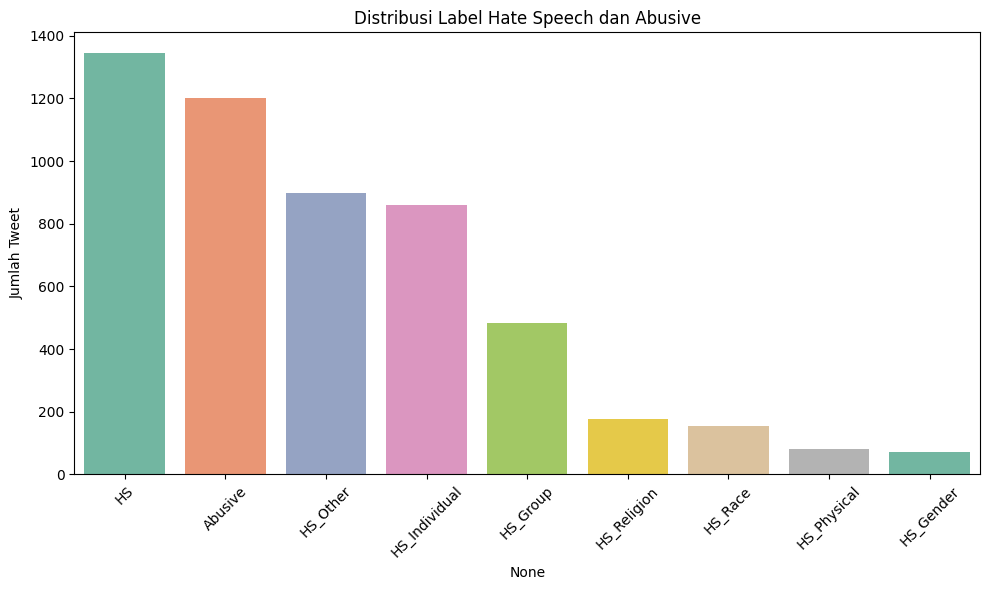

In [ ]:
# EDA: Distribusi Label
label_columns = df.columns[1:]
label_counts = df[label_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title("Distribusi Label Hate Speech dan Abusive")
plt.xticks(rotation=45)
plt.ylabel("Jumlah Tweet")
plt.tight_layout()
plt.show()

Penjelasan Grafik:
- Dominasi dua kategori utama: "HS" dan "Abusive" memiliki jumlah tweet tertinggi, mengindikasikan mereka adalah label paling umum — ini akan mempengaruhi distribusi label dalam model klasifikasi.
- Subkategori minoritas: Misalnya "HS_Physical" atau "HS_Gender" berjumlah sangat sedikit. Ini menunjukkan adanya ketidakseimbangan kelas (class imbalance) yang perlu ditangani saat pelatihan model.
- Tingkat granularitas: Label-label seperti "HS_Race" dan "HS_Religion" memberikan label kontekstual yang lebih sempit dari "HS", dan kemungkinan bisa saling overlap (karena ini multilabel).


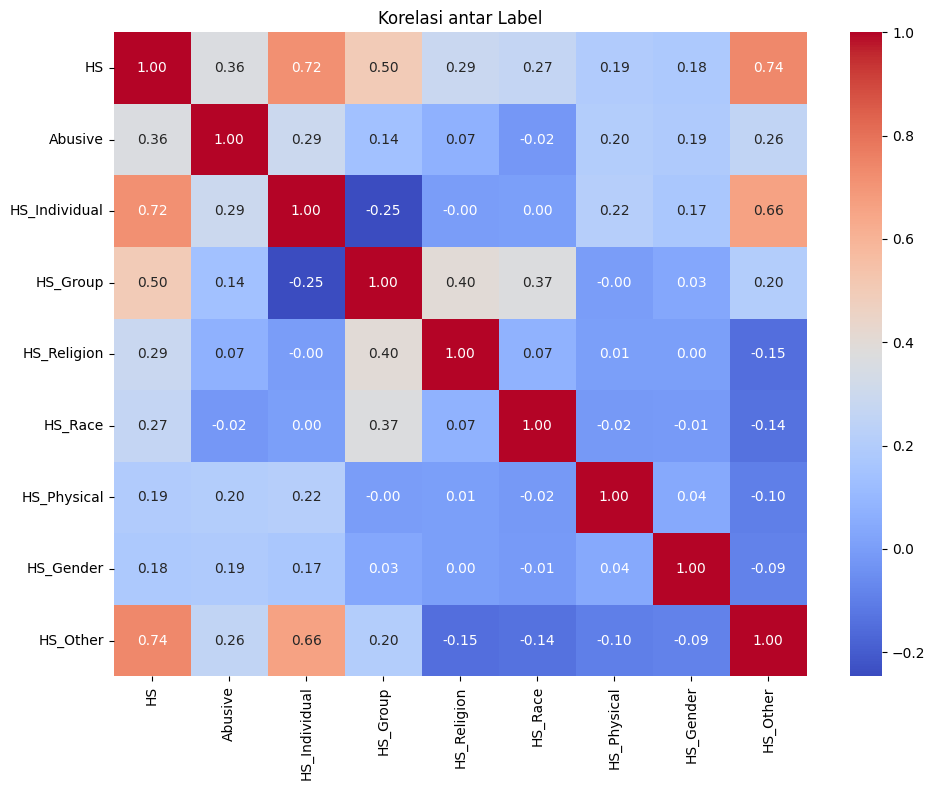

In [ ]:
# EDA: Korelasi antar Label
correlation_matrix = df[label_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi antar Label")
plt.tight_layout()
plt.show()

Penjelasan Grafik:
- HS dan HS_Other memiliki korelasi tinggi (0.74) → artinya tweet yang mengandung hate speech secara umum sering juga diberi label HS_Other.
- HS dengan HS_Individual (0.72) → menunjukkan bahwa ujaran kebencian sering diarahkan ke individu.
- HS_Group dengan HS_Religion (0.59) dan HS_Race (0.55) → menyiratkan kelompok yang disasar cenderung berdasarkan agama atau ras.

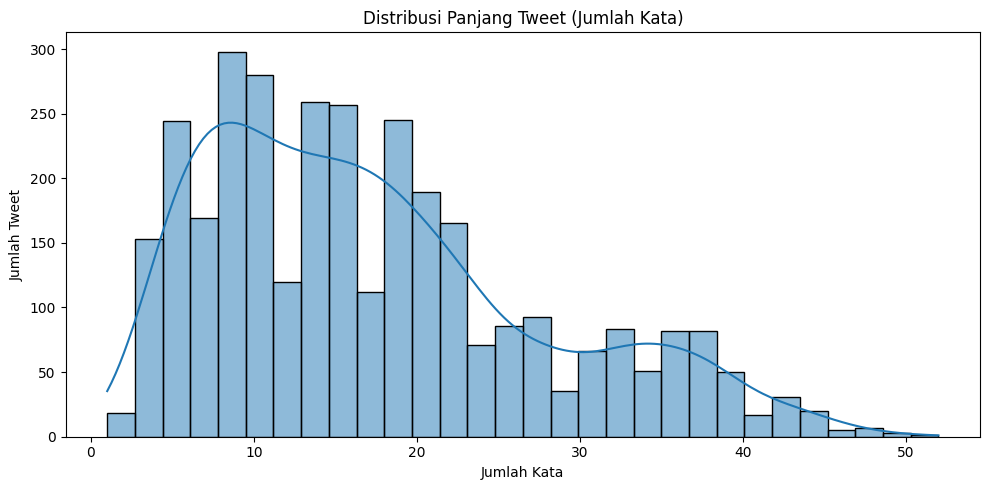

In [ ]:
# EDA: Panjang Tweet
df['tweet_length'] = df['Tweet'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribusi Panjang Tweet (Jumlah Kata)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Tweet")
plt.tight_layout()
plt.show()

Penjelasan Grafik:
- Distribusi cenderung right-skewed: Mayoritas tweet berada di kisaran 10–15 kata, lalu frekuensinya menurun secara perlahan seiring bertambahnya panjang tweet.
- Ada sedikit tweet yang sangat panjang—mungkin mengindikasikan bahwa pengguna Twitter lebih sering menggunakan kalimat singkat, atau karena ada batasan karakter.
- Bisa terlihat nilai mode-nya (panjang yang paling sering muncul) berada sekitar 10–12 kata.

## B.

In [ ]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'USER', '', text)  # remove USER tag
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # URLs
    text = re.sub(r"[^a-z\s]", '', text)  # remove special chars and digits
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_text'] = df['Tweet'].apply(preprocess_text)

In [ ]:
# Tokenisasi untuk LSTM
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
max_len = 52  # sesuai hasil EDA
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

Tokenisasi dan Padding
- Menggunakan Tokenizer Keras dengan parameter oov_token='<OOV>' untuk menangani kata yang tidak dikenal (out-of-vocabulary).
- fit_on_texts() membentuk kosakata (vocabulary).
- texts_to_sequences() mengubah teks menjadi urutan angka.
- Kemudian, dengan pad_sequences(...), setiap input disamakan panjangnya menjadi 52 token berdasarkan hasil EDA sebelumnya.

In [ ]:
# Label Encoding Multilabel
X = padded_sequences
y = df[label_columns].values

Label Encoding untuk Multilabel
- y = df[label_columns].values: Mengambil label multilabel dalam bentuk array biner (shape = (n_samples, n_labels)), misalnya 9 label seperti HS, Abusive, dsb.
- Struktur ini mendukung prediksi banyak label per tweet, bukan hanya satu.

In [ ]:
# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2304, 52) (2304, 9)
Validation shape: (494, 52) (494, 9)
Test shape: (494, 52) (494, 9)


Output menunjukkan:
- Train set: 2,304 sampel
- Validation dan Test: masing-masing 494 sampel
- Tiap input berupa vektor sepanjang 52 (hasil padding), dan labelnya memiliki 9 kolom biner.

## C.

### 1. LSTM Model (dengan Keras)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
# Hyperparameter
embedding_dim = 128
lstm_units = 64  # ← hyperparameter 1
dropout_rate = 0.5  # ← hyperparameter 2
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Build Model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='sigmoid')  # sigmoid for multilabel
])

# Compile Model
model_lstm.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=1e-3),
                   metrics=['accuracy'])

model_lstm.build(input_shape=(None, max_len))
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 52, 128)        │     1,614,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,668,489 (6.36 MB)

 Trainable params: 1,668,489 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2741 - loss: 0.5310 - val_accuracy: 0.8684 - val_loss: 0.3823
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6345 - loss: 0.4112 - val_accuracy: 0.8684 - val_loss: 0.3811
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6301 - loss: 0.3998 - val_accuracy: 0.8684 - val_loss: 0.3860
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7311 - loss: 0.4034 - val_accuracy: 0.8684 - val_loss: 0.3837
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7561 - loss: 0.4052 - val_accuracy: 0.8684 - val_loss: 0.3834


In [ ]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model - Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")

LSTM Model - Test Loss: 0.3887, Test Accuracy: 0.8462


### 2. IndoBERT Model (Pretrained LLM from HuggingFace)

In [ ]:
# !pip install transformers datasets evaluate

In [ ]:
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [ ]:
# Load pretrained base model
bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p1")
max_len = 128
num_labels = y.shape[1]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Custom model for multilabel classification
class BertMultilabelModel(Model):
    def __init__(self, bert, num_labels):
        super(BertMultilabelModel, self).__init__()
        self.bert = bert
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = Dense(num_labels, activation='sigmoid')

    def call(self, inputs, **kwargs):
        output = self.bert(inputs)[1]  # pooled output
        output = self.dropout(output)
        return self.classifier(output)

model_bert = BertMultilabelModel(bert_model, num_labels)

# Compile
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), # Initial learning rate
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])


dummy_input = tf.constant([[1] * max_len])
_ = model_bert(dummy_input)
model_bert.summary()

# Note: The tuned model was compiled with a different learning rate (1e-6) later.

Model: "bert_multilabel_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 9)                 │         6,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,921 (27.04 KB)

 Trainable params: 6,921 (27.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Hyperparameter Tuning for IndoBERT

# Define new hyperparameters
new_learning_rate = 1e-6  # Smaller learning rate
new_epochs = 7 # Increased epochs

# Re-compile the model with the new learning rate
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

print(f"Compiled IndoBERT model with Learning Rate: {new_learning_rate} and Epochs: {new_epochs}")

Compiled IndoBERT model with Learning Rate: 1e-06 and Epochs: 7


In [ ]:
# Create the datasets for training and validation for the BERT model
from transformers import AutoTokenizer
import tensorflow as tf

tokenizer_bert = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

def encode_fn(text_list):
    return tokenizer_bert(text_list, padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')

train_texts = df_train['clean_text'].tolist()
train_labels = df_train[label_columns].values

val_texts = df_val['clean_text'].tolist()
val_labels = df_val[label_columns].values

test_texts = df_test['clean_text'].tolist()
test_labels = df_test[label_columns].values

train_encodings = encode_fn(train_texts)
val_encodings = encode_fn(val_texts)
test_encodings = encode_fn(test_texts)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(32)

In [ ]:
# Train the IndoBERT model with the new hyperparameters
history_bert_tuned = model_bert.fit(train_dataset, validation_data=val_dataset, epochs=new_epochs)

Epoch 1/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - accuracy: 0.5595 - loss: 0.7424 - val_accuracy: 0.5729 - val_loss: 0.6224
Epoch 2/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.5861 - loss: 0.5975 - val_accuracy: 0.5891 - val_loss: 0.5241
Epoch 3/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.6205 - loss: 0.5143 - val_accuracy: 0.6134 - val_loss: 0.4684
Epoch 4/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 331ms/step - accuracy: 0.6382 - loss: 0.4673 - val_accuracy: 0.6134 - val_loss: 0.4360
Epoch 5/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - accuracy: 0.6321 - loss: 0.4397 - val_accuracy: 0.6215 - val_loss: 0.4162
Epoch 6/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - accuracy: 0.6267 - loss: 0.4226 - val_accuracy: 0.6336 - val_loss: 0.4032
Epoch 7/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.6336 - loss: 0.4113 - val_accuracy: 0.6437 - val_loss: 0.3943


In [ ]:
# Evaluate the tuned IndoBERT model on the test set
bert_tuned_loss, bert_tuned_accuracy = model_bert.evaluate(test_dataset, verbose=0)
print(f"Tuned IndoBERT Model - Test Loss: {bert_tuned_loss:.4f}, Test Accuracy: {bert_tuned_accuracy:.4f}")

Tuned IndoBERT Model - Test Loss: 0.4015, Test Accuracy: 0.6296


# D.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict IndoBERT
y_pred_bert_prob = model_bert.predict(test_dataset)
y_pred_bert_bin = (y_pred_bert_prob > 0.5).astype(int)

# Evaluation Function
def multilabel_metrics(y_true, y_pred, average='macro'):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

# Calculate Metrics
metrics_bert = multilabel_metrics(test_labels, y_pred_bert_bin)

# Print Results
print("📊 IndoBERT Metrics:")
for k, v in metrics_bert.items():
    print(f"{k.capitalize()}: {v:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step
📊 IndoBERT Metrics:
Accuracy: 0.3623
Precision: 0.2835
Recall: 0.0520
F1: 0.0758


In [ ]:
# Predict on the test set using the LSTM model
y_pred_lstm_proba = model_lstm.predict(X_test)

# Display the shape of the predictions
print("Shape of LSTM predictions (probabilities):", y_pred_lstm_proba.shape)

# Display a few sample predictions (probabilities)
print("\nSample LSTM predictions (probabilities) for the first 5 test samples:")
print(y_pred_lstm_proba[:5])

# Check the distribution of predicted probabilities
print("\nMin, Max, Mean of LSTM predicted probabilities:")
print("Min:", np.min(y_pred_lstm_proba))
print("Max:", np.max(y_pred_lstm_proba))
print("Mean:", np.mean(y_pred_lstm_proba))

# Check how many predictions are above the 0.5 threshold
predictions_above_threshold = np.sum(y_pred_lstm_proba > 0.5)
print(f"\nNumber of individual label predictions > 0.5 threshold: {predictions_above_threshold}")

# Check how many samples have at least one label predicted above 0.5
samples_with_positive_prediction = np.sum(np.any(y_pred_lstm_proba > 0.5, axis=1))
print(f"Number of test samples with at least one label predicted > 0.5: {samples_with_positive_prediction}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Shape of LSTM predictions (probabilities): (494, 9)

Sample LSTM predictions (probabilities) for the first 5 test samples:
[[0.42092115 0.33785486 0.24321291 0.13923715 0.04475424 0.03783458
  0.02147381 0.01752019 0.30749092]
 [0.42092097 0.33785605 0.24321432 0.13923886 0.04475524 0.03783552
  0.02147432 0.01752068 0.3074918 ]
 [0.42092097 0.33785626 0.24321458 0.13923915 0.04475543 0.03783568
  0.02147441 0.01752076 0.30749196]
 [0.42092106 0.3378552  0.24321334 0.13923766 0.04475453 0.03783485
  0.02147396 0.01752032 0.30749115]
 [0.42092013 0.33785984 0.24321853 0.13924405 0.04475807 0.03783824
  0.02147581 0.01752211 0.30749393]]

Min, Max, Mean of LSTM predicted probabilities:
Min: 0.017520092
Max: 0.42096
Mean: 0.17449367

Number of individual label predictions > 0.5 threshold: 0
Number of test samples with at least one label predicted > 0.5: 0


In [ ]:
# Evaluate LSTM model on Test set with a lower threshold
def evaluate_model_with_threshold(model, X, y_true, dataset_name, threshold=0.5):
    loss, accuracy = model.evaluate(X, y_true, verbose=0)
    print(f"{dataset_name} Loss: {loss:.4f}")
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")

    # Get predictions (probabilities)
    y_pred_proba = model.predict(X)

    # Convert probabilities to binary predictions using the specified threshold
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate multilabel specific metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{dataset_name} Precision (weighted, threshold={threshold}): {precision:.4f}")
    print(f"{dataset_name} Recall (weighted, threshold={threshold}): {recall:.4f}")
    print(f"{dataset_name} F1-score (weighted, threshold={threshold}): {f1:.4f}")
    print("-" * 30)

print("📊 LSTM Metrics:")
evaluate_model_with_threshold(model_lstm, X_test, y_test, "LSTM Test", threshold=0.3)

📊 LSTM Metrics:
LSTM Test Loss: 0.3888
LSTM Test Accuracy: 0.8462
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM Test Precision (weighted, threshold=0.3): 0.2409
LSTM Test Recall (weighted, threshold=0.3): 0.6641
LSTM Test F1-score (weighted, threshold=0.3): 0.3521
------------------------------


1. Akurasi (Accuracy)
- IndoBERT: 0.3623
- LSTM: 0.8462

Analisis: Akurasi LSTM jauh lebih tinggi dibandingkan IndoBERT. Namun, dalam klasifikasi multilabel, metrik accuracy seringkali tidak mencerminkan kinerja sebenarnya, karena nilai ini hanya mengukur seberapa sering keseluruhan label pada suatu sampel diprediksi benar — sangat ketat dan bisa misleading.

2. Precision
- IndoBERT: 0.2835
- LSTM: 0.2409

Analisis: IndoBERT memiliki precision sedikit lebih tinggi, artinya prediksinya cenderung lebih "hati-hati" — lebih jarang memberikan label yang salah. Namun nilai ini hanya separuh cerita karena recall-nya sangat rendah.

3. Recall
- IndoBERT: 0.0520
- LSTM: 0.6641

Analisis: Ini perbedaan paling signifikan. LSTM berhasil "menangkap" lebih banyak label yang benar dibanding IndoBERT. Recall IndoBERT sangat rendah, artinya model hanya memunculkan sangat sedikit label aktif dalam prediksinya (sering memprediksi nol).

4. F1-Score (Harmonis Precision & Recall)
- IndoBERT: 0.0758
- LSTM: 0.3521

Analisis: F1 LSTM unggul jauh, menunjukkan keseimbangan antara precision dan recall yang lebih baik. F1-score IndoBERT sangat rendah karena recall-nya hampir nol.

# E.

LINK VIDEO:https://binusianorg-my.sharepoint.com/personal/darrius_salim_binus_ac_id/_layouts/15/guestaccess.aspx?share=EQEKvBlCiLlEtEzIYvcPXhoBfoKOkBgAvR3Sj1NWTTAXMA&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=CrsoUk